In [28]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub

from sklearn.preprocessing import KBinsDiscretizer,  LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, adjusted_rand_score


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
!chcp 65001
path = %pwd

Active code page: 65001


In [4]:
api.dataset_download_files("uciml/iris", path = path, unzip = True)

Dataset URL: https://www.kaggle.com/datasets/uciml/iris


In [5]:
os.listdir()

['.ipynb_checkpoints', '3 лаба.ipynb', 'database.sqlite', 'Iris.csv']

In [173]:
df_train = pd.read_csv('iris.csv')
df_train

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [174]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [175]:
df_train.duplicated().sum()

np.int64(0)

In [176]:
df_train = df_train.drop_duplicates()

In [177]:
df_train.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [178]:
len(df_train)

150

In [179]:
df_train.drop(columns=["Id"], inplace=True)

In [223]:
num_features = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
n_bins = 3  

In [224]:
df_train[num_features].duplicated().sum()

np.int64(3)

In [225]:
discretizer = KBinsDiscretizer(n_bins=n_bins, encode="onehot-dense", strategy="uniform")
X_discrete = discretizer.fit_transform(df_train[num_features].drop_duplicates())

In [226]:
binary_features = [f"{col}_bin{i}" for col in num_features for i in range(n_bins)]
df_binary = pd.DataFrame(X_discrete, columns=binary_features)
df_binary["Species"] = df_train["Species"]

In [227]:
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(df_binary['Species'])

In [228]:
class HopfieldNetwork:
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
        self.weights = np.zeros((n_neurons, n_neurons))
    
    def train(self, patterns):
        for p in patterns:
            p = p * 2 - 1  
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)
    
    def recall(self, patterns, steps=5):
        results = []
        for p in patterns:
            p = p * 2 - 1  
            for _ in range(steps):
                p = np.sign(self.weights @ p)
            results.append((p + 1) // 2)  
        return np.array(results)

In [229]:
X_discrete.shape[1]

12

In [230]:
hopfield_net = HopfieldNetwork(n_neurons=X_discrete.shape[1])
hopfield_net.train(X_discrete)
y_hopfield_full = hopfield_net.recall(X_discrete)

In [231]:
y_hopfield_full

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [238]:
np.mean(X_discrete == y_hopfield_full) * 100

np.float64(87.35827664399093)

In [233]:
clusters = len(df_binary['Species'].unique())

In [234]:
kmeans_hopfield = KMeans(n_clusters=clusters, random_state=42)
y_hopfield = kmeans_hopfield.fit_predict(y_hopfield_full)

D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [235]:
kmeans = KMeans(n_clusters=clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_discrete)

D:\anaconda\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [236]:
silhouette_hopfield = silhouette_score(X_discrete, y_hopfield)
silhouette_kmeans = silhouette_score(X_discrete, kmeans_labels)

print(f"Silhouette Score - Hopfield: {silhouette_hopfield:.4f}")
print(f"Silhouette Score - K-Means: {silhouette_kmeans:.4f}")

Silhouette Score - Hopfield: 0.4696
Silhouette Score - K-Means: 0.5274


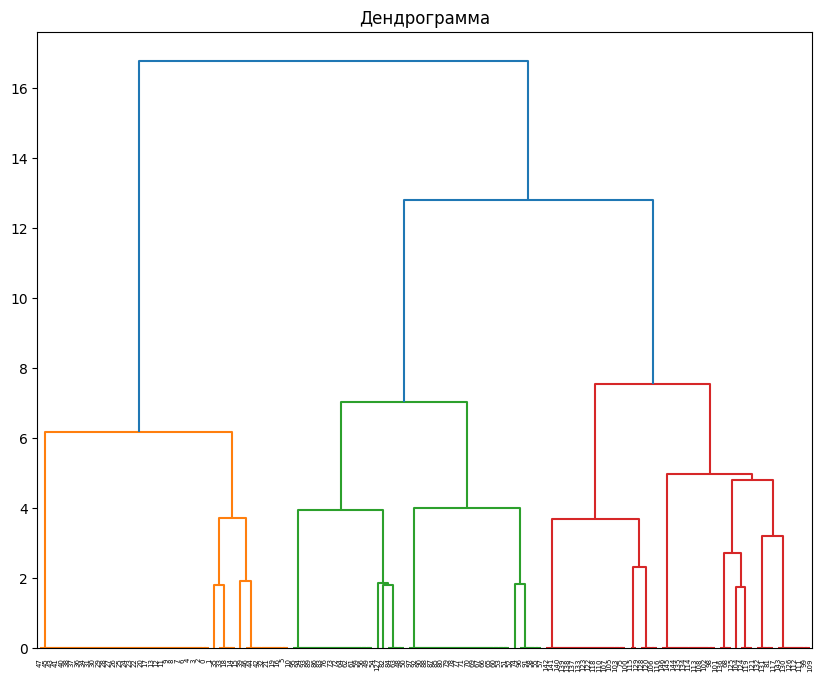

In [237]:
linked = linkage(X_discrete, method = 'ward')

plt.figure(figsize=(10, 8))
dendrogram(linked, orientation='top')
plt.grid(False)
plt.title('Дендрограмма')
plt.show()